# Statistical models and PPL

In [2]:
# import required libraries
import numpy as np                   
import matplotlib.pyplot as plt  

import time
import sys
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

## What is a statistical model?

Statistical modelling is all about sampling and probabilities. In a statistical model, calls to random number generators are common, distributions are sampled  from to create events and probabilities of events occuring are evaluated. The same model may produce different outcomes if provided the same starting conditions but a different random number seed. (climate/weather example, diagram to explain this better?)

## Bayesian Statistics in Climate and Weather

In Bayesian statistics, probability is viewed as a degree of belief of an event occurring (in contrast to frequentist statistics where probability is the frequency of an event occurring). The Bayesian view of probability is valuable in climate and weather forecasting. It allows us to quantify how likely we expect an event to be, such as the probability of rain in Exeter this afternoon. 

In Bayesian statistics, we can incorporate a prior probability: our degree of belief of event occurring before observing any evidence. Say its July in Exeter- we would expect rain to be quite unlikely. Then, we observe some evidence and update our degree of belief about the event occurring. Say we look out the window and observe some data: we see there are many dark clouds in the sky. So we can update our degree of belief of rain occurring this afternoon. 

$$P({\sf rain \, later}|{\sf weather\, now\,=cloudy}) =  \frac{P({\sf weather now | \sf rain later}) P({\sf rain later})}{P({\sf weather now})}$$


P(X|Y) is the conditional probability of A, given the observed state of B (clouds in this case). This is often called conditioning on observations.

It turns out this is really useful and has many applications in climate and weather science. One important example is data assimilation: incorporating observed data from satellites about the current state of the atmosphere into the weather model for prediction of the future state of the atmosphere.

One of the advantages of probabilistic programming is that this step is made simpler. We can easily "condition" on observations.


## What is a probabilistic programming language (PPL)?

The traditional approach to constructing statistical models can be time-consuming and requires expertise. Typically it involves statisticians writing down the problem on paper and carrying out a mathematical procedure to design a bespoke statistical model. This would then be translated into code to construct a model ready for use. Since the model is specifically designed for the task at hand, this method must be repeated for each new problem. 

Probabilistic programming languages are designed to make this process simpler, quicker and less technical. The idea is to remove the need for the expert statistician to hand-design the statistical model, by embedding this step within the programming language itself. Statistical tasks such as encoding observations (conditioning) and learning latent variables (inference) are automated and some of the complicated mathematical and statistical steps are hidden from the user. This makes statistical modelling more accessible to non-experts and tasks that traditionally require a lot of thought and hand-engineering can be automated.

More simply, a PPL is an ordinary programming language, equipped with tools that make statistical modelling easier for the user, reducing the need for hand-designing programs. It's useful for analysis and inference from data: not for writing software.

Also, probabilistic programming languages are not new. They have been around since Simula in 1966 [Dahl and Nygaard 1966] However, with the rise of deep learning, they are growing in popularity, with many new PPLs designed with inference for machine learning in mind (pyro, Edward, PyMC3, https://en.wikipedia.org/wiki/Probabilistic_programming)
https://www.cs.ubc.ca/~poole/papers/IndependentChoices.pdf


http://adriansampson.net/doc/ppl.html

## What does Probabalistic Programming involve? 

The main components of a probablistic programming language are:

(1) Sampling: Our model is probabilistic- it requires sampling from probability distributions.
(2) Conditioning: We have some observed data that can be used to update probabilities
(3) Inference: We can learn something from the known data and model. This could be a "latent variable", some underlying factor that you can't directly observe but might influence the data. This is usually the hard part.

Probabalistic programming is a suitable choice when we have a probabalistic model, that relies on sampling from distributions in order to make predictions. PPL makes it easier to do conditioning on observed data and to learn something about the model. 

## Simple Example: Propagate Single Particle

We will introduce a simple example to show how probabilistic programming works. Let's say we have a particle moving through the atmosphere with some speed. We observe it after 10 seconds but with some measurement error. We want to use a probabilistic approach to find the distribution of the speed of propagation. 

The speed is something we can't directly observe- its a hidden variable. In our simple model, we will sample from a normal distribution, with an initial `guess` for the speed. Then the particle is moved a distance of speed x time. The final position is observed with some measurement error.

We'll be using pyro (https://pyro.ai/examples/index.html) to  
want to backpropagate some information 
this could be applied to any model- and use for more complicated things

## (1) Probabilistic Model
The first step is building a probabilistic model, which involves the first component of PPL, sampling. A probabilistic model takes samples from a distribution. In pyro we provide a unique name for each variable, which we will see is useful later on.

In [3]:
import numpy as np 
import torch
import pyro
import pyro.distributions as dist

def propagate_cloud(guess=5.,guess_sd=2.,time=10.):
    """ Parameters:
    guess = our initial guess for the speed of particle
    guess_sd = our guess for the standard deviation of the particle speed
    time = length of time before observing """
    # sample from prior distribution
    speed = pyro.sample("speed", dist.Normal(guess, guess_sd))  
    position_final = speed * time
    # final position is observed with a bit of noise from our measurement tools
    position_observed = pyro.sample("position",dist.Normal(position_final,10))
    return(speed,position_observed)


This is the model. Note the `pyro.sample` statements that allow us to sample from a distribution. This is 

Plot a histogram to check this function returns a different speed and position each time.

In [209]:
import matplotlib.pyplot as plt
def plot_hist(hist1,hist2=None,name1="",name2="",label1="",label2="",true_dist=None):
    fig = plt.figure(figsize=(10,4))
    ax1 = plt.subplot2grid((1, 2), (0, 0));
    ax1.hist(hist1,25,density=True,label=label1,alpha=0.7);
    ax1.axvline(np.mean(hist1),c="k",ls="--");
    plt.title(name1);
    if hist2 is not None:
        ax2 = plt.subplot2grid((1, 2), (0, 1));
        ax2.hist(hist2,25,density=True,label=label2,alpha=0.7);
        ax2.axvline(np.mean(hist2),c="k",ls="--");
        plt.title(name2);
    if true_dist is not None:
        # Exact posterior distribution of speed: provide tuple for mu and sigma
        exact_mu,exact_sigma =  true_dist
        x = np.linspace(-5.,15., 100);
        f = 1./(exact_sigma * np.sqrt(2 * np.pi)) * np.exp( - (x - exact_mu)**2 / (2 * exact_sigma**2))
        for ax in fig.axes:
            ax.plot(x, f, lw=2,label="Exact",color="red");
            ax.axvline(exact_mu,ls="--",color="red");
            ax.legend();

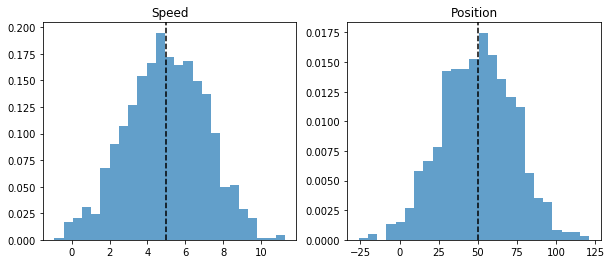

In [210]:
uncond = [propagate_cloud(guess=5.,guess_sd=2.) for i in range(1000)]
speed_uncond,pos_uncond = zip(*uncond)
plot_hist(speed_uncond,pos_uncond,"Speed","Position")

## 2) Conditioning

What if we observe the particle at a certain point, x=30m ? We want to use this information in our model to learn more about the latent variable- speed. This is when we condition on our observations. We need to update our model, so that the outcome is always 1.8. 

In pyro, this is done with the `pyro.condition` statement for the named variable "position". This statement returns a new function almost identical to the original, but overwrites the `pyro.sample("position",...)` by fixing it at the observed value. The rest of the function remains the same. Let's check this:


In [7]:
position_observed = 30
conditioned_propagate = pyro.condition(propagate_cloud,
                                       data={"position": position_observed})

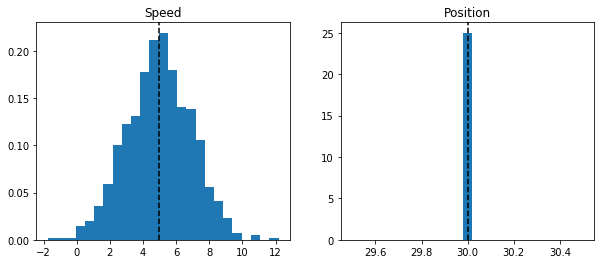

In [196]:
cond = [conditioned_propagate() for i in range(1000)]
speed_cond,pos_cond = zip(*cond)
plot_hist(speed_cond,pos_cond,"Speed","Position")

## 3) Inference
The next step is inference- the difficult part. The aim is to find the posterior distribution of the latent variable, (speed), given the model and the observations.

$$({\sf speed} \, | \, {\sf guess}, {\sf position}_{\sf observed}  = 1.8) \sim \, ? $$


In some scenarios there may be an analytical form of this distribution. But if not, we can use the stochastic variational inference algorithm. This requires a distribution that approximates the posterior distribution, which is called the variational distribution or the "guide" for short. This distribution relies on additional parameters called variational parameters, that will be tuned to "guide" it towards the posterior distribution. 

For this example, the speed is sampled from a normal distribution with mean and variance given by the variational parameters, a and b. These are defined with the statement `pyro.param(...)`. This stores the values of the parameters in something called the "Parameter Store", so they can accessed and updated later. The initial values of a is the guess and the initial value of b is 1. These parameters will be optimised in stochastic variational inference. Also note that the variance, b, is constrained to be positive.

In [14]:
from torch.distributions import constraints
def guide(guess=5.,guess_sd=2.,time=10.):
    """ The guide (or variational distribution) approximates 
    the posterior distribution, using extra variational parameters,
    a and b, to sample from the speed distribution. """
    a = pyro.param("a", torch.tensor(guess))
    b = pyro.param("b", torch.tensor(guess_sd),constraint=constraints.positive)
    speed = pyro.sample("speed", dist.Normal(a,b))
    return speed

We can plot some samples from the guide, in the same way as before. Note that the guide returns the speed as a tensor (hence the  `.item()` to get the values for the histogram).

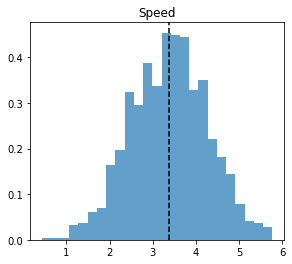

In [211]:
# Distribution of guide before any optimisation
speed_guide = [guide().item() for i in range(1000)]
plot_hist(speed_guide,name1="Speed")


## Stochastic Variational Inference
We have created a family of guide functions, indexed by named parameters, and want to search for the member of that family that is the best approximation to the posterior distribution, according to some loss function- we'll use the Evidence Lower Bound Operator or "ELBO" (link to why). We use stochastic variational inference , `pyro.infer.SVI`, to optimise the parameters of the guide so that sampling from the guide produces a distribution for `speed` consistent with the model conditioned on observations. 


In [173]:
pyro.clear_param_store()
from pyro.optim import Adam
adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
svi = pyro.infer.SVI(model=conditioned_propagate, 
                     guide=guide,
                     optim=optimizer,
                     loss=pyro.infer.Trace_ELBO())

losses, a,b  = [], [], []
num_steps = 20000
for t in range(num_steps):
    losses.append(svi.step())
    a.append(pyro.param("a").item())
    b.append(pyro.param("b").item())

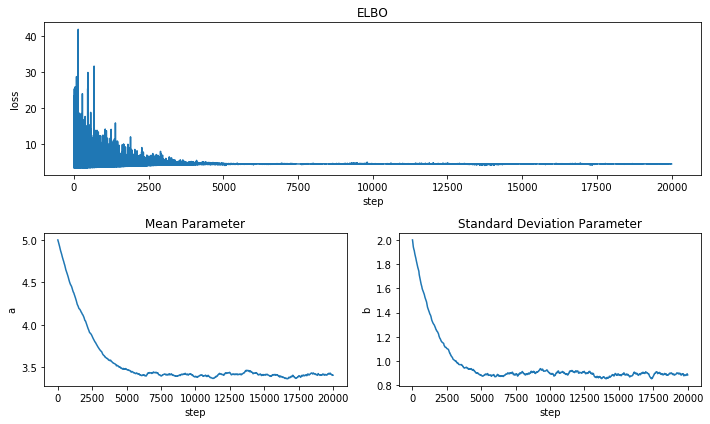

In [176]:
fig = plt.figure(figsize=(10,6));
ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2);
ax1.plot(losses);
ax1.set(xlabel="step",ylabel="loss",title="ELBO");
ax2 = plt.subplot2grid((2, 2), (1, 0));
ax2.plot(a);
ax2.set(xlabel="step",ylabel="a",title="Mean Parameter");
ax3 = plt.subplot2grid((2, 2), (1, 1));
ax3.plot(b);
ax3.set(xlabel="step",ylabel="b",title="Standard Deviation Parameter");
plt.tight_layout();

Once converged, we have a value of `a` and `b` that can be used in the guide to sample from the speed given the model and the observations. This is an approximation to the posterior distribution. We can also compare this to the analytic speed, which can be calculated for this simple example:

In [179]:
print("Mean = {:.2f}, Standard Deviation = {:.2f}".format(np.mean(a[10000:20000]),np.mean(b[10000:20000])))

Mean = 3.41, Standard Deviation = 0.89


In [96]:
speed_obs_mean = 30./10.
speed_obs_sd = 10./10.
guess=5.
guess_sd=2.
exact_mean = (speed_obs_sd**2 * guess + guess_sd**2 * speed_obs_mean)/(speed_obs_sd**2 + guess_sd**2) 
exact_sd = np.sqrt(guess_sd**2/((guess_sd**2 + speed_obs_sd**2)))
print(exact_mean)
print(exact_sd)

3.4
0.8944271909999159


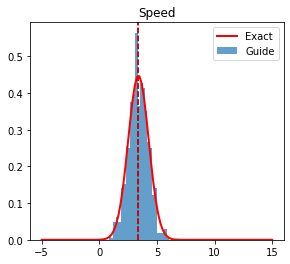

In [213]:
# Distribution of guide before any optimisation
speed_guide = [guide().item() for i in range(1000)]
plot_hist(speed_guide,name1="Speed",label1="Guide",true_dist=(3.4,0.89))

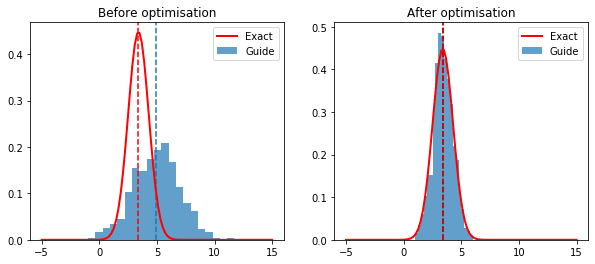

In [206]:
fig = plt.figure(figsize=(10,4))
# Distribution of guide before any optimisation
ax1 = plt.subplot2grid((1, 2), (0, 0));
ax1.hist(speed_guide,20,density=True,label="Guide",alpha=0.7);
ax1.axvline(np.mean(speed_guide),ls="--");
plt.title('Before optimisation');

# Distribution of guide after optimisation
ax2 = plt.subplot2grid((1, 2), (0, 1));
ax2.hist(new_speed_guide,20,density=True,label="Guide",alpha=0.7);
ax2.axvline(np.mean(new_speed_guide),c="k",ls="--");
plt.title('After optimisation');

# Exact posterior distribution of speed
exact_mu =  3.4
exact_sigma = 0.89
x = np.linspace(-5.,15., 100);
ax1.plot(x, 1./(exact_sigma * np.sqrt(2 * np.pi)) * 
         np.exp( - (x - exact_mu)**2 / (2 * exact_sigma**2) ),
         lw=2,label="Exact",color="red");
ax1.axvline(exact_mu,ls="--",color="red");
ax2.plot(x, 1./(exact_sigma * np.sqrt(2 * np.pi)) * 
         np.exp( - (x - exact_mu)**2 / (2 * exact_sigma**2) ),
         lw=2,label="Exact",color="red");
ax2.axvline(exact_mu,ls="--",color="red");
ax1.legend();
ax2.legend();

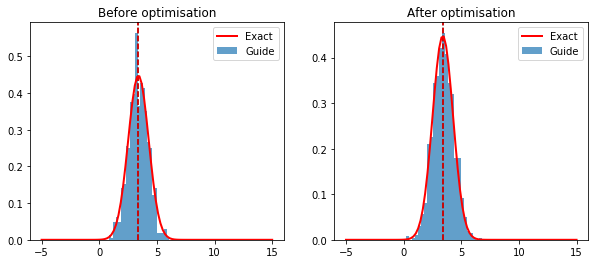

In [215]:
#Distribution of guide after optimisation
new_speed_guide = [guide().item() for i in range(1000)]
plot_hist(speed_guide,new_speed_guide,"Before optimisation","After optimisation",
          label1="Guide",label2="Guide",true_dist=(3.4,0.89))